# Algoritmo PanTompkins
Algoritmo implementado para detectar a ocorrência do pico QRS em um sinal ECG. Foi desenvolvido por Jiapu Pan e Willis J. Tompkins em 1985 e publicado no journal "IEEE Transactions on Biomedical Engineering".
<br>
<p align="center">
<img src="imagem/pantompkins.png" height="250" width="800">
</p>

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

## Carregar o sinal

O sinal utiliziado nesse notebook foi na frequência de 1kHz, diferente do original de 200Hz.

In [22]:
record, fields = wfdb.rdsamp("database_part/s0004_re", channels=[0])

Plotar os dados

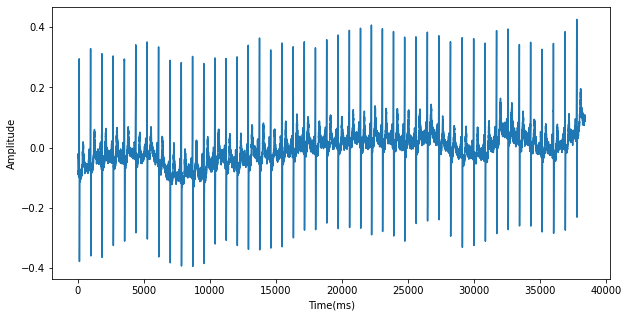

In [23]:
tamanho = np.linspace(0, len(record), num = len(record))
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho, record)

## Filtro Passa Faixa
De acordo com o artigo de Pan, J., & Tompkins, deseja-se um filtro passa faixa entre 5 e 15 Hz. Isso porque é onde maximiza a energia do intervalo QRS.

### Filtro Passa Baixa

Função de transferência do filtro passa baixa:
<br>

$$H(z) = \frac{1}{32}\frac{(1 - z^{-6})^2}{(1 - z^{-1})^2}$$
<br>

Equação da diferença:
$$y(n) = 2y(n - 1) - y(n - 2) + \frac{1}{32}[x(n) - 2x(n - 6) + x(n - 12)]$$

In [24]:
#Funcao da equacao
def passa_baixa(sinal):
    lowpass = np.copy(sinal)
    for i in range(12,len(lowpass)-1):
        lowpass[i] = (2*lowpass[i-1]) - (lowpass[i-2]) + (sinal[i] - (2*sinal[i-6]) + sinal[i-12])
    return lowpass 

teste_passab = passa_baixa(record)



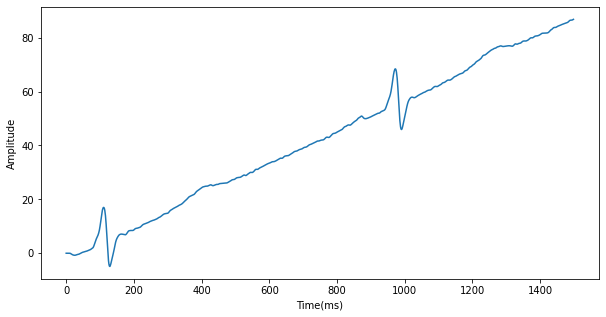

In [25]:
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho[:1500], teste_passab[:1500])

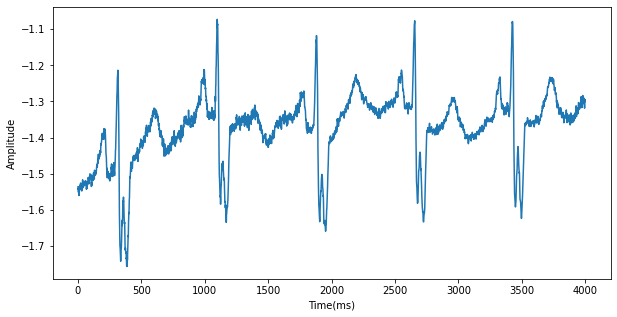

In [8]:
#Funcao de transferencia pronta na biblio scilab
x1 = sig.lfilter([1,0,0,0,0,0,-2,0,0,0,0,0,1],[1,-2,1],record)
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho[0:4000], x1[0:4000])

### Filtro Passa Alta

Função de transferência do filtro passa baixa:
<br>

$$H(z) = \frac{(1 - z^{-32})}{(1 - z^{-1})}$$
<br>

Equação da diferença:
$$y(n) = y(n-1) - \frac{x(n)}{32} + x(n-16) - x(n-17) + \frac{x(n-32)}{32}$$

In [26]:
def passa_alta(sinal):
    hightpass = np.copy(sinal)
    for i in range(32,len(hightpass)-1):
        hightpass[i] = hightpass[i-1] - (sinal[i]/32) + sinal[i-16] - sinal[i-17] + (sinal[i-32]/32)
    return hightpass

teste_passaa = passa_alta(record)

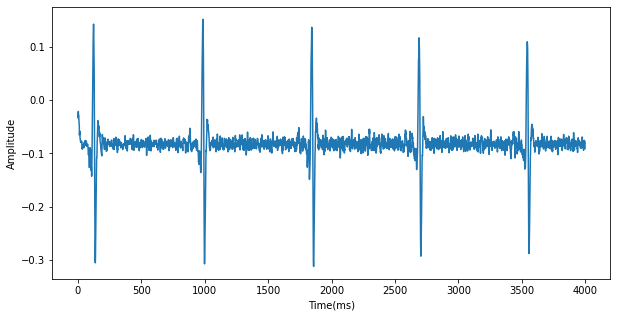

In [27]:
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho[0:4000], teste_passaa[0:4000])

In [28]:
filtrado = passa_baixa(record)
filtrado = passa_alta(filtrado)

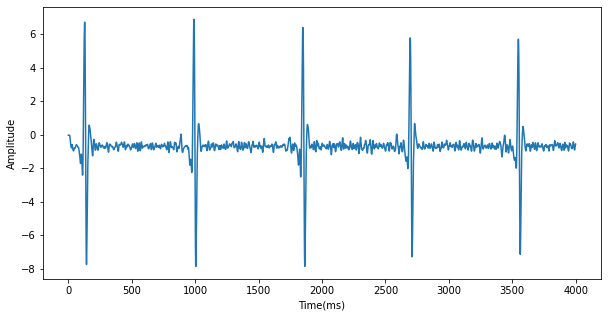

In [29]:
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho[0:4000], filtrado[0:4000])

$$y(n) = \frac{1}{8}[2x(n) + x(n-1) - x(n-3) - 2x(n - 4)]$$

In [30]:
def diferencial(sinal):
    derivative = np.copy(sinal)
    for i in range(len(derivative)-1):
        derivative[i] = (1/8)*(2*sinal[i] + sinal[i-1] - sinal[i-3] - 2*sinal[i-4])
    return derivative
    
deriv_teste = diferencial(filtrado)

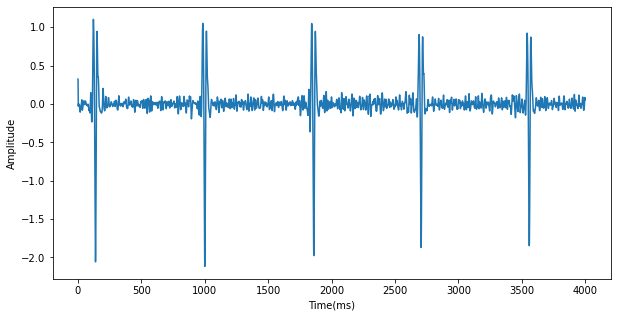

In [31]:
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho[0:4000], deriv_teste[0:4000])

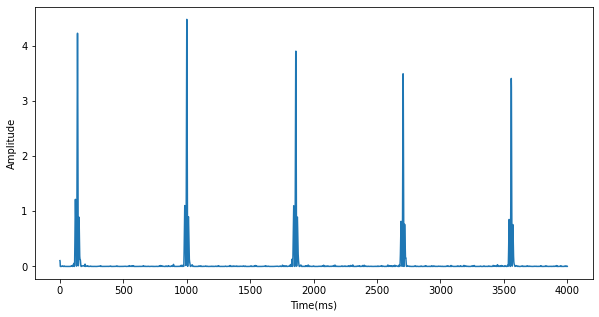

In [32]:
deriv_teste = np.power(deriv_teste,2)
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho[0:4000], deriv_teste[0:4000])

$$y(n) =\frac{1}{N}(x[n − (N − 1)] + x[n − (N − 2)] + · · · + x(n)$$

In [16]:
#Frequencia utilizada = 1kHz
#N é o tamanho da janela integrada
N = 40
def integration(n, sinal):
    integra = np.copy(sinal)
    for i in range(len(integra)):
        # Fazer somatorio primeiro
        somatorio = 0
        for j in range(n):
            somatorio = somatorio + sinal[i-(n-j)] 
        integra[i] = 1/n * somatorio
    return integra

In [33]:
deriv_teste = integration(N,deriv_teste)

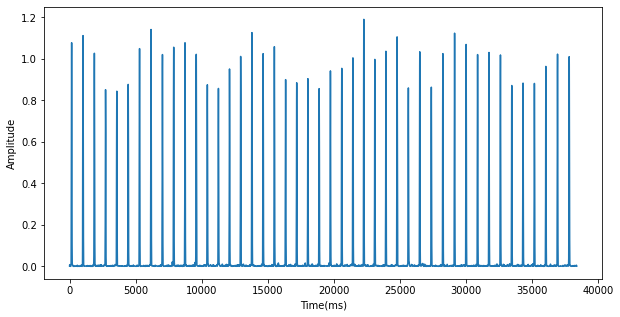

In [34]:
plt.figure(figsize=(10,5))
plt.xlabel(xlabel="Time(ms)")
plt.ylabel(ylabel="Amplitude")
plt.plot(tamanho, deriv_teste)

In [20]:
def pan_peak(sinal):
    '''Se passar de um determinado limiar
    detecta uma subida e salva esse ponto
    a hora que passa abaixo do limiar salva o ponto de descida.
    O pico será a mediana entre os sinais.
    Retorna os momento dos picos.
    '''
    limiar = 0.8
    digital_b = 0 # Verifica o limiar no momento anterior
    digital_a = 0 # Verifica o limiar no momento atual
    subida = [] # posicai de subida
    descida = [] # posicao de descida
    pos = [] # posicao dos picos
    sig = passa_baixa(sinal)
    sig = passa_alta(sig)
    sig = diferencial(sig)
    sig = np.power(sig,2)
    sig = integration(40, sig)

    for x in range(len(sig)):
        #verificacao de limiar
        if sig[x] > limiar:
            digital_a = 1
        else:
            digital_a = 0
        #verificacao de subida
        if digital_a == 1 and digital_b == 0:
            subida.append(x)
        #verificacao de descida
        if digital_a == 0 and digital_b == 1:
            descida.append(x)
            
        digital_b = digital_a
        
    for x in range(len(descida)):
        pos.append(subida[x] + ((descida[x] - subida[x]) // 2))
    
    return pos

In [21]:
pan_peak(record)

[]

In [4]:
fields

{'fs': 1000,
 'sig_len': 38400,
 'n_sig': 1,
 'base_date': None,
 'base_time': None,
 'units': ['mV'],
 'sig_name': ['i'],
 'comments': ['age: 79',
  'sex: female',
  'ECG date: 14/08/1990',
  'Diagnose:',
  'Reason for admission: Myocardial infarction',
  'Acute infarction (localization): infero-postero-lateral',
  'Former infarction (localization): no',
  'Additional diagnoses: Diabetes mellitus',
  'Smoker: no',
  'Number of coronary vessels involved: 1',
  'Infarction date (acute): 10-Aug-90',
  'Previous infarction (1) date: n/a',
  'Previous infarction (2) date: n/a',
  'Hemodynamics:',
  'Catheterization date: n/a',
  'Ventriculography: n/a',
  'Chest X-ray: n/a',
  'Peripheral blood Pressure (syst/diast): n/a',
  'Pulmonary artery pressure (at rest) (syst/diast): n/a',
  'Pulmonary artery pressure (at rest) (mean): n/a',
  'Pulmonary capillary wedge pressure (at rest): n/a',
  'Cardiac output (at rest): n/a',
  'Cardiac index (at rest): n/a',
  'Stroke volume index (at rest): n

In [6]:
fields["comments"]

['age: 79',
 'sex: female',
 'ECG date: 14/08/1990',
 'Diagnose:',
 'Reason for admission: Myocardial infarction',
 'Acute infarction (localization): infero-postero-lateral',
 'Former infarction (localization): no',
 'Additional diagnoses: Diabetes mellitus',
 'Smoker: no',
 'Number of coronary vessels involved: 1',
 'Infarction date (acute): 10-Aug-90',
 'Previous infarction (1) date: n/a',
 'Previous infarction (2) date: n/a',
 'Hemodynamics:',
 'Catheterization date: n/a',
 'Ventriculography: n/a',
 'Chest X-ray: n/a',
 'Peripheral blood Pressure (syst/diast): n/a',
 'Pulmonary artery pressure (at rest) (syst/diast): n/a',
 'Pulmonary artery pressure (at rest) (mean): n/a',
 'Pulmonary capillary wedge pressure (at rest): n/a',
 'Cardiac output (at rest): n/a',
 'Cardiac index (at rest): n/a',
 'Stroke volume index (at rest): n/a',
 'Pulmonary artery pressure (laod) (syst/diast): n/a',
 'Pulmonary artery pressure (laod) (mean): n/a',
 'Pulmonary capillary wedge pressure (load): n/a',

In [9]:
print(fields["comments"][4])

Reason for admission: Myocardial infarction
